NAO-based heat budget model is used to reconstruct heat content variability and reconstructions are also comapred against the actual timeseries. These analyses are used to compute ocean memory for the subpolar North Atlantic to compare ocean decadal variability between climate model outputs and observational datasets. 

In [1]:
import xarray as xr
import numpy as np
import scipy.stats as sc
import matplotlib.pyplot as plt
import glob
import xskillscore as xs

import matplotlib.image as image
import matplotlib.patches as patches

import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmaps
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import warnings
warnings.filterwarnings("ignore")

In [2]:
def Moving_Avg(ds, time = 1., time_len = 12):
    
    """Compute moving averages
    Parameters
    ----------
    ds : xarray Dataset for data variables
    time : time values for computing weights
    time_len : number of grid points for moving avg
    
    Returns
    -------
    ds_avg : Dataset containting moving avg
    """
    
    if(len(time) == 1):
        
        ds_avg = ds.rolling(time = time_len, center = True).mean('time')
        
    else: 
    
        days = time.dt.daysinmonth
        
        ds_avg = ((ds * days).rolling(time = time_len, center = True).mean('time') /
                  days.rolling(time = time_len, center = True).mean('time'))
    
    return ds_avg

def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

def detrend(da, dims, deg=1):
    # detrend along multiple dimensions
    # only valid for linear detrending (deg=1)
    da_detrended = da
    for dim in dims:
        da_detrended = detrend_dim(da_detrended, dim, deg=deg)
    return da_detrended

## Figure 3: NAO-based reconstructions and ocean memory calculation

In [3]:
ppdir = "/gws/nopw/j04/snapdragon/hkhatri/CMIP6_Ctr_Hist/"

exp = 'piControl'
source_id = ['MOHC/HadGEM3-GC31-MM/', 'NOAA-GFDL/GFDL-CM4/', 'IPSL/IPSL-CM6A-LR/', 'NCAR/CESM2/'] 

ds = []
ds_cor = []
ds_vol = []

for model in source_id:

    d = xr.open_dataset(ppdir + model + exp + "/Predicting_Heat_Content_SST_piControl.nc", use_cftime=True)

    ds.append(d)

    d3 = xr.open_dataset(ppdir + model + exp + "/Cell_Volume.nc")
    if(model == 'NCAR/CESM2/'):
        d3 = d3.sel(lev=slice(0.,20000.)).sum('lev') # get data in upper 200 m        
    else:
        d3 = d3.sel(lev=slice(0.,200.)).sum('lev') # get data in upper 200 m

    ds_vol.append(d3)

    d1 = xr.open_dataset(ppdir + model + exp + "/Correlations_Heat_Content_SST_piControl.nc", use_cftime=True)

    ds_cor.append(d1.sel(tau=slice(0., 11.), beta=slice(0.,6.)))

print(ds[0], ds_cor[0])

exp1 = 'historical'
source_id = ['MOHC/HadGEM3-GC31-MM/', 'NOAA-GFDL/GFDL-CM4/', 'IPSL/IPSL-CM6A-LR/', 'NCAR/CESM2/'] 

dsh = []
dsh_cor = []

for model in source_id:

    dir_list = glob.glob(ppdir + model + exp1 + "/r*")

    d2 = []
    d2_cor = []

    for dir1 in dir_list:

        dir_name = dir1.split('/')[-1].split(',')[0]

        # read historical timeseries

        d = xr.open_dataset(ppdir + model + exp1 + "/" + dir_name + "/Predicting_Heat_Content_SST_historical.nc", use_cftime=True)

        d2.append(d)
        
        d1 = xr.open_dataset(ppdir + model + exp1 + "/" + dir_name + "/Correlations_Heat_Content_SST_historical.nc", use_cftime=True)

        d2_cor.append(d1.sel(timescale=slice(0., 61.))) #,tau=slice(0., 11.), beta=slice(0.,6.)))

    d2 = xr.concat(d2, dim="r")
    d2_cor = xr.concat(d2_cor, dim="r")

    dsh_cor.append(d2_cor)
    dsh.append(d2)

ds_cor_hist = xr.open_dataset(ppdir + "Observations/Predict_Correlations_Heat_Content_SST_Observations.nc")
ds_cor_hist = ds_cor_hist.sel(timescale=slice(0., 61.)) #,tau=slice(0., 11.), beta=slice(0.,6.))

<xarray.Dataset>
Dimensions:       (tau: 40, beta: 21, time: 6000)
Coordinates:
  * time          (time) object 1850-01-16 00:00:00 ... 2349-12-16 00:00:00
    month         (time) int64 ...
  * tau           (tau) float64 0.5 1.0 1.5 2.0 2.5 ... 18.0 18.5 19.0 19.5 20.0
  * beta          (beta) float64 0.0 0.5 1.0 1.5 2.0 ... 8.0 8.5 9.0 9.5 10.0
Data variables:
    HC200_Pred    (tau, beta, time) float32 ...
    HC200_actual  (time) float32 ...
    SST_Pred      (tau, beta, time) float32 ...
    SST_actual    (time) float32 ... <xarray.Dataset>
Dimensions:              (tau: 22, beta: 13, time: 6000, HP_LP: 2, timescale: 98)
Coordinates:
  * tau                  (tau) float64 0.5 1.0 1.5 2.0 ... 9.5 10.0 10.5 11.0
  * beta                 (beta) float64 0.0 0.5 1.0 1.5 2.0 ... 4.5 5.0 5.5 6.0
  * time                 (time) object 1850-01-16 00:00:00 ... 2349-12-16 00:...
    month                (time) int64 ...
  * timescale            (timescale) float64 2.0 3.0 4.0 5.0 ... 97.0 9

Memory =  7.947078869103753  +-  3.111308616834593  years
Monthly - Max Corr =  0.6421256 , Timescale =  6.283185307179586
Chosen reconstructions =  418.0
Correlation on decadal timescales (local + non-local effects) =  0.5280909732437058  +-  0.07406372896888122
Correlation on decadal timescales (local effects) =  0.20316472948694198  +-  0.13990461750633615
 
Memory =  7.88373605699925  +-  1.8423527516839997  years
Monthly - Max Corr =  0.5021123 , Timescale =  7.0685834705770345
Chosen reconstructions =  260.0
Correlation on decadal timescales (local + non-local effects) =  0.525533367220747  +-  0.03746941155996317
Correlation on decadal timescales (local effects) =  0.3244942139862676  +-  0.0927900438613203
 
Memory =  7.808260587758479  +-  1.8003142354229535  years
Monthly - Max Corr =  0.52561265 , Timescale =  7.5398223686155035
Chosen reconstructions =  255.0
Correlation on decadal timescales (local + non-local effects) =  0.33158263175091085  +-  0.02719112305321349
Correl

Text(0.025, 0.15, 'Ocean Memory = 17.7$\\pm$6.91 years')

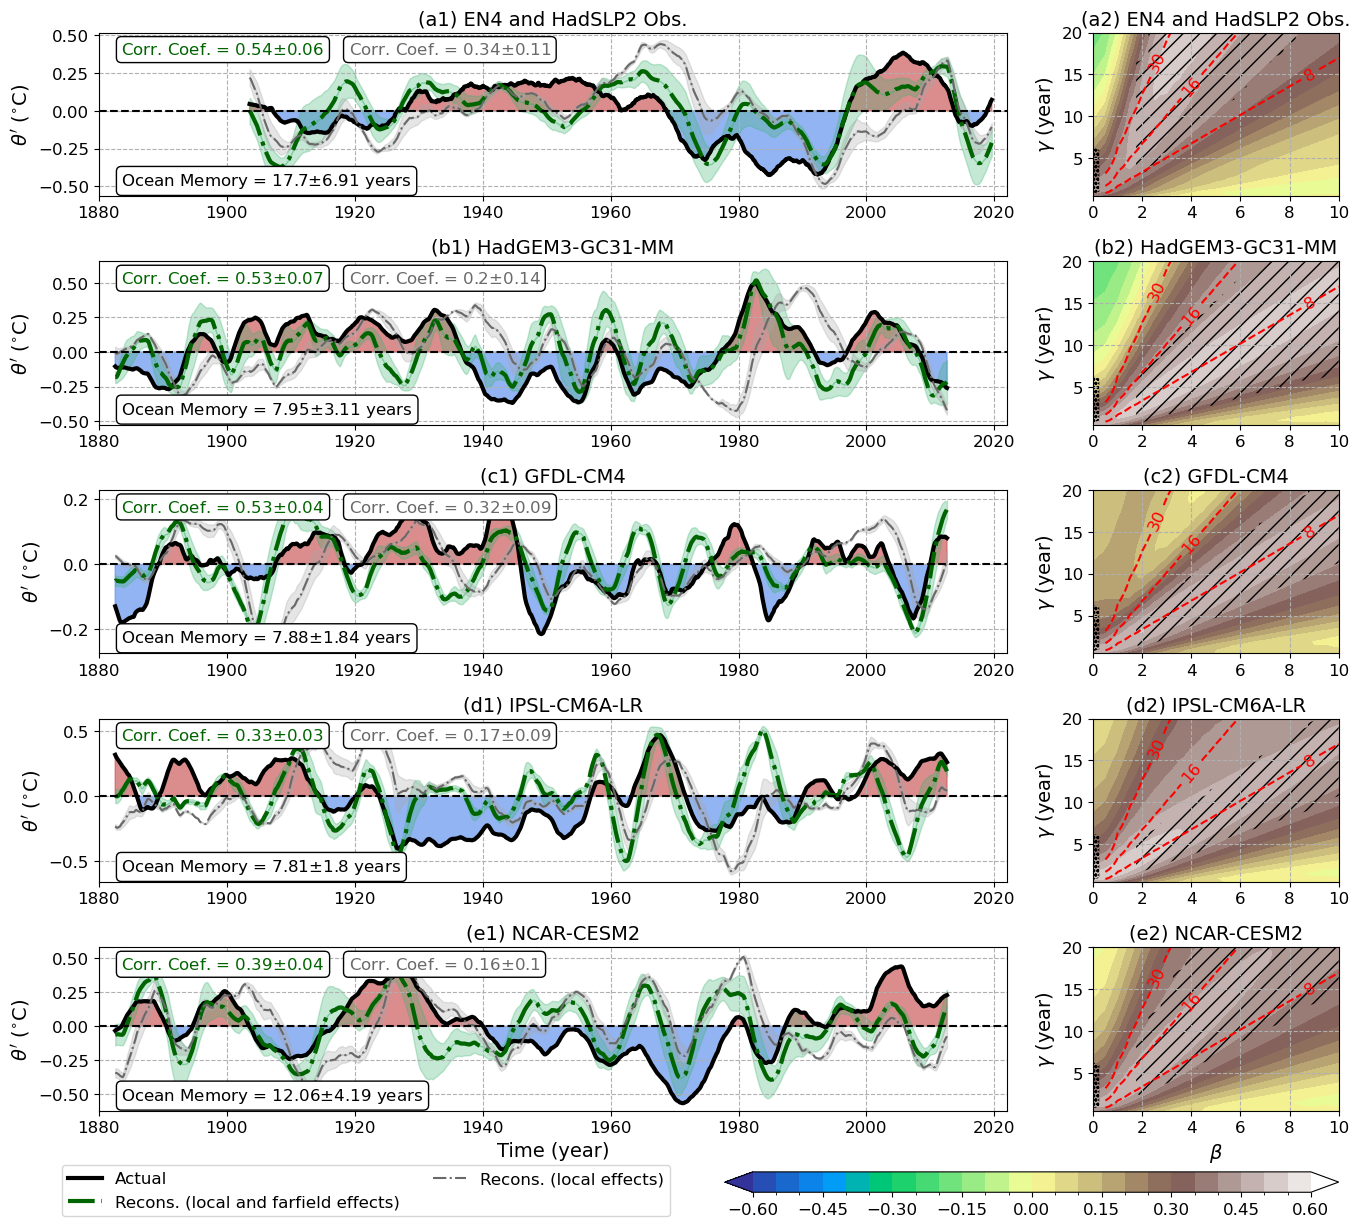

In [4]:
# Correlations for smoothed timeseries (variations faster than 1 year removed)
# Even with monthly timeseries, correlation coefficeints change insignificantly

legend_list = ['HadGEM3-GC31-MM', 'GFDL-CM4', 'IPSL-CM6A-LR', 'NCAR-CESM2']

grid1 = plt.GridSpec(5, 4, wspace=0.35, hspace=0.4)
fig = plt.figure(figsize=[16,14])

hatch_dense = 2
tau_win = 2.
fs = 14

for i in range(0, len(ds)):

    tau_beta = dsh_cor[i]['tau'] * 1.5 * np.pi / dsh_cor[i]['beta']

    # cmip hostorical runs
    ax = fig.add_subplot(grid1[i+1, 3])

    tmp_r = dsh_cor[i]['HC200_Corr_r']
    tmp_p = dsh_cor[i]['HC200_Corr_p']

    tmp_mean = tmp_r.mean('r') #.where(tmp_p.mean('r') < 0.01)
    p = tmp_mean.plot.contourf(ax=ax, x='beta', y='tau', levels = 25, vmin = -.6, vmax = .6,
                                                 cmap='terrain', add_labels=False, add_colorbar=False, extend='both')

    # Choose members for anomaly reconstruction (set tau>=1. and corr. > 0.4)
    corr_r = dsh_cor[i]['HC200_Corr_r'].isel(r = 0)
    tau_beta = corr_r['tau'] * 1.5 * np.pi / corr_r['beta']
    cor_max = (corr_r).where(corr_r==corr_r.max(), drop=True).squeeze()
    tau_beta_max = cor_max['tau'].values * 1.5 * np.pi / cor_max['beta'].values
    mem_chose = corr_r.where((corr_r > 0.4) & (corr_r['tau']>= 1.))
    mem_chose = mem_chose.where(tau_beta < -corr_r['tau'] * np.log(0.05)) # to ensure memory < 3*tau, 95% damping of anomalies 
    mem_chose = mem_chose.where(dsh_cor[i]['HC200_Corr_p'].isel(r=0) < 0.01) # significance levels at 99%

    ax.contourf(dsh_cor[i]['beta'], dsh_cor[i]['tau'], ((mem_chose<1.) & (mem_chose>-1.)), colors='none', 
                levels=[.5,1.,1.5, 2.], hatches=[hatch_dense*'/'], extend='upper')

    mem_chose = corr_r.where((corr_r['tau']>= 1.) & (corr_r['tau']<= 6.) & (corr_r['beta']== 0.))
    ax.contourf(dsh_cor[i]['beta'], dsh_cor[i]['tau'], ((mem_chose<1.) & (mem_chose>-1.)), colors='none', 
                levels=[.5,1.,1.5, 2.], hatches=[2*'oo'], extend='upper')
    
    # ocean memory isolines
    CS = ax.contour(dsh_cor[i]['beta'], dsh_cor[i]['tau'], tau_beta, [8., 16., 30.], linewidths=1.5, linestyles='--', colors='r')
    ax.clabel(CS, CS.levels, inline=True, fontsize=12)

    ax.set_ylabel(r'$\gamma$ (year)',fontsize=fs)
    if(i == 3):
        ax.set_xlabel(r'$\beta$',fontsize=fs)
    ax.grid(ls='--')
    ax.set_title('(' + chr(98+i) + '2) '+ legend_list[i],fontsize=fs)
    plt.xticks(fontsize=12); plt.yticks(fontsize=12);

    ax1 = ax

ax = fig.add_subplot(grid1[0, 3])

tau_beta = ds_cor_hist['tau'] * 1.5 * np.pi / ds_cor_hist['beta']

p = ds_cor_hist['HC200_Corr_r'].plot.contourf(ax=ax, x='beta', y='tau', levels = 25, vmin = -.6, vmax = .6,
                                            cmap='terrain', add_labels=False, add_colorbar=False, extend='both')

# Choose members for anomaly reconstruction
corr_r = ds_cor_hist['HC200_Corr_r']
tau_beta = corr_r['tau'] * 1.5 * np.pi / corr_r['beta']
cor_max = corr_r.where(corr_r==corr_r.max(), drop=True).squeeze()
tau_beta_max = cor_max['tau'].values * 1.5 * np.pi / cor_max['beta'].values

mem_chose = corr_r.where((corr_r > 0.4) & (corr_r['tau']>= 1.)) # arbitrary cut-off
mem_chose = mem_chose.where(tau_beta < -corr_r['tau'] * np.log(0.05))
mem_chose = mem_chose.where(ds_cor_hist['HC200_Corr_p'] <0.01)

ax.contourf(ds_cor_hist['beta'], ds_cor_hist['tau'], ((mem_chose<1.) & (mem_chose>-1.)), colors='none', 
            levels=[.5,1.,1.5, 2.], hatches=[hatch_dense*'/'], extend='upper')

mem_chose = corr_r.where((corr_r['tau']>= 1.) & (corr_r['tau']<= 6.) & (corr_r['beta']== 0.))
ax.contourf(ds_cor_hist['beta'], ds_cor_hist['tau'], ((mem_chose<1.) & (mem_chose>-1.)), colors='none', 
            levels=[.5,1.,1.5, 2.], hatches=[2*'oo'], extend='upper')

CS = ax.contour(ds_cor_hist['beta'], ds_cor_hist['tau'], tau_beta, [8., 16., 30.], linewidths=1.5, linestyles='--', colors='r')
ax.clabel(CS, CS.levels, inline=True, fontsize=12)

ax.set_ylabel(r'$\gamma$ (year)',fontsize=fs)
ax.grid(ls='--')
ax.set_title('(a2) EN4 and HadSLP2 Obs.',fontsize=fs)
plt.xticks(fontsize=12); plt.yticks(fontsize=12);

#ax1.append(ax)

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

axins = inset_axes(ax1, width="100%",  # width = 5% of parent_bbox width
                   height="5%",  # height : 50% 
                   loc='lower left', bbox_to_anchor=(-1.5, -0.5, 2.5, 2.5),
                   bbox_transform=ax1.transAxes,
                   borderpad=0,)

cb = fig.colorbar(p, cax=axins, extend='both', orientation="horizontal")
cb.ax.tick_params(labelsize=12)

# ------------------ 
rho_cp = 4.09 * 1.e6 # constant from Williams et al. 2015
mov_avg = 60
year_cut = 1880

for j in range(0,len(dsh)):

    tim = dsh[j]['time.year'] + dsh[j]['time.month'] / 12
    tim = tim.sel(time = dsh[j]['time.year'] >= year_cut)

    ax = fig.add_subplot(grid1[j+1, 0:3])
    
    cor_max = dsh_cor[j]['HC200_Corr_r'].assign_coords(r = np.arange(len(dsh_cor[j]['r'])))
    r1 = 0 #len(cor_max['r']) - 1 #0 #cor_max['r'].values;
    
    cor_max = cor_max.where(cor_max==cor_max.isel(r=r1).max(), drop=True).squeeze()
    

    tmp = dsh[j]['Heat_Content_North_Atlantic_subpolar'] / (ds_vol[j]['Volume_North_Atlantic_subpolar'] * rho_cp)

    tmp = tmp.sel(time = tmp['time.year'] >= year_cut) 
    tmp = detrend(tmp, ['time'])
    days = tmp['time'].dt.daysinmonth
    tmp= tmp - (tmp*days).sum('time') / days.sum('time')

    tmp1 = Moving_Avg(tmp.isel(r=r1), time = tmp['time'], time_len = mov_avg)

    ax.plot(tim, tmp1, lw=3.0, ls='-', color='k', label='Actual')
    ax.fill_between(tim, tmp1.where(tmp1<0), alpha=0.7, color='cornflowerblue')
    ax.fill_between(tim, tmp1.where(tmp1>0), alpha=0.7, color='indianred')

    # get reconstructed timeseries with standard deviation
    corr_r = dsh_cor[j]['HC200_Corr_r'].isel(r = r1)
    tau_beta = corr_r['tau'] * 1.5 * np.pi / corr_r['beta']
    cor_max = (corr_r).where(corr_r==corr_r.max(), drop=True).squeeze()
    tau_beta_max = cor_max['tau'].values * 1.5 * np.pi / cor_max['beta'].values

    tmp_pred = dsh[j]['HC200_Pred'].isel(r=r1)
    tmp_pred = tmp_pred.sel(time = tmp_pred['time.year'] >= year_cut)
    tmp_pred = detrend(tmp_pred, ['time'])
    days = tmp_pred['time'].dt.daysinmonth
    tmp_pred = tmp_pred - (tmp_pred*days).sum('time') / days.sum('time')
    tmp_pred = Moving_Avg(tmp_pred, time = tmp_pred['time'], time_len = mov_avg)
    
    # choose correlation points
    mem_chose = corr_r.where((corr_r > 0.4) & (corr_r['tau']>= 1.)) # arbitrary cut-off
    mem_chose = mem_chose.where(tau_beta < -corr_r['tau'] * np.log(0.05))
    mem_chose = mem_chose.where(dsh_cor[j]['HC200_Corr_p'].isel(r=r1) <0.01)
    
    tmp_pred1 = tmp_pred.where((mem_chose<1.) & (mem_chose>-1.)) # get timeseries for chosen correlation points

    tmp_pred1 = tmp_pred1 * tmp1.std('time') / tmp_pred1.std('time')
    std_error = tmp_pred1.std(['tau', 'beta'])

    tmp_mean = tmp_pred1.mean(['tau', 'beta']).compute()

    ax.plot(tim, tmp_mean, lw=3.0, ls='-.', color='darkgreen', label='Recons. (local and farfield effects)')
    ax.fill_between(tim, tmp_mean, tmp_mean + std_error, alpha=0.3, color='mediumseagreen')
    ax.fill_between(tim, tmp_mean, tmp_mean - std_error, alpha=0.3, color='mediumseagreen')

    memory = tau_beta.where((mem_chose<1.) & (mem_chose>-1.))

    print("Memory = ", memory.mean(['tau', 'beta']).values,  " +- ", memory.std(['tau', 'beta']).values, " years")
    print("Monthly - Max Corr = ", cor_max.values, ", Timescale = ", tau_beta_max)
    print("Chosen reconstructions = ", (mem_chose/mem_chose).sum().values)
    cor = xs.pearson_r(tmp1, tmp_pred1, dim='time', skipna=True)
    print("Correlation on decadal timescales (local + non-local effects) = ", cor.mean(['tau', 'beta']).values, 
          " +- ",cor.std(['tau', 'beta']).values)

    # if only consider simple damping without change in sign of temperature anomalies
    mem_chose = corr_r.where((corr_r['tau']>= 1.) & (corr_r['tau']<= 6.) & (corr_r['beta']== 0.))

    tmp_pred1 = tmp_pred.where((mem_chose<1.) & (mem_chose>-1.)) # get timeseries for chosen correlation points
    tmp_pred1 = tmp_pred1 * tmp1.std('time') / tmp_pred.std('time')
    std_error = tmp_pred1.std(['tau', 'beta'])
    tmp_mean = tmp_pred1.mean(['tau', 'beta']).compute()

    ax.plot(tim, tmp_mean, lw=1.5, ls='-.', color='dimgrey', label='Recons. (local effects)')
    ax.fill_between(tim, tmp_mean, tmp_mean + std_error, alpha=0.3, color='darkgrey')
    ax.fill_between(tim, tmp_mean, tmp_mean - std_error, alpha=0.3, color='darkgrey')

    cor1 = xs.pearson_r(tmp1, tmp_pred1, dim='time', skipna=True)
    print("Correlation on decadal timescales (local effects) = ", cor1.mean(['tau', 'beta']).values, 
          " +- ",cor1.std(['tau', 'beta']).values)

    print(" ")

    ax.grid(ls='--')
    ax.axhline(y=0., ls='--', color='k')
    ax.set_xlim([year_cut, 2022])
    ax.set_title('(' + chr(98+j) + '1) '+ legend_list[j],fontsize=fs)
    plt.xticks(fontsize=12); plt.yticks(fontsize=12);
    ax.set_ylabel(r'$\theta^{\prime}$ ($^{\circ}$C)', fontsize=fs);

    # place a text box for correlation coefficients
    props = dict(boxstyle='round', facecolor='white', alpha=1.)
    txt = (r'Corr. Coef. = ' + str(np.round(cor.mean(['tau', 'beta']).values,2)) + 
           r'$\pm$' + str(np.round(cor.std(['tau', 'beta']).values,2)))
    ax.text(0.025, 0.945, txt, transform=ax.transAxes, fontsize=12, color='darkgreen', verticalalignment='top', bbox=props)
    txt = (r'Corr. Coef. = ' + str(np.round(cor1.mean(['tau', 'beta']).values,2)) + 
           r'$\pm$' + str(np.round(cor1.std(['tau', 'beta']).values,2)))
    ax.text(0.275, 0.945, txt, transform=ax.transAxes, fontsize=12, color='dimgrey', verticalalignment='top', bbox=props)
    txt = (r'Ocean Memory = ' + str(np.round(memory.mean(['tau', 'beta']).values,2)) + 
       r'$\pm$' + str(np.round(memory.std(['tau', 'beta']).values,2)) + ' years')
    ax.text(0.025, 0.15, txt, transform=ax.transAxes, fontsize=12, color='black', verticalalignment='top', bbox=props)

ax.set_xlabel(r'Time (year)', fontsize=fs);
ax.legend(loc='upper left', bbox_to_anchor=(-0.05, -0.28), fontsize=12, ncol=2)

tim = ds_cor_hist['time.year'] + ds_cor_hist['time.month'] / 12
tim = tim.sel(time = ds_cor_hist['time.year'] >= year_cut)

ax = fig.add_subplot(grid1[0, 0:3])

tmp_obs = ds_cor_hist['Heat_Content_North_Atlantic_subpolar']
tmp_pred = ds_cor_hist['HC200_Pred']

# linear detrending and time-mean removal
tmp_obs = detrend(tmp_obs, ['time']) 
tmp_pred = detrend(tmp_pred, ['time'])

days = tmp_obs['time'].dt.daysinmonth
tmp_obs = tmp_obs - (tmp_obs*days).sum('time') / days.sum('time')
tmp_pred = tmp_pred - (tmp_pred*days).sum('time') / days.sum('time')

tmp_obs = Moving_Avg(tmp_obs, time = tmp_obs['time'], time_len = mov_avg)
tmp_pred = Moving_Avg(tmp_pred, time = tmp_pred['time'], time_len = mov_avg)

ax.plot(tim, tmp_obs, lw=3.0, ls='-', color='k', label='Actual')
ax.fill_between(tim, tmp_obs.where(tmp_obs<0), alpha=0.7, color='cornflowerblue')
ax.fill_between(tim, tmp_obs.where(tmp_obs>0), alpha=0.7, color='indianred')

corr_r = ds_cor_hist['HC200_Corr_r']
tau_beta = corr_r['tau'] * 1.5 * np.pi / corr_r['beta']
cor_max = corr_r.where(corr_r==corr_r.max(), drop=True).squeeze()
tau_beta_max = cor_max['tau'].values * 1.5 * np.pi / cor_max['beta'].values

# choose correlation points
mem_chose = corr_r.where((corr_r > 0.4) & (corr_r['tau']>= 1.)) # arbitrary cut-off
mem_chose = mem_chose.where(tau_beta < -corr_r['tau'] * np.log(0.05))
mem_chose = mem_chose.where(ds_cor_hist['HC200_Corr_p'] <0.01)

tmp_pred1 = tmp_pred.where((mem_chose<1.) & (mem_chose>-1.)) # get timeseries for chosen correlation points

tmp_pred1 = tmp_pred1 * tmp_obs.std('time') / tmp_pred1.std('time')
std_error = tmp_pred1.std(['tau', 'beta'])

tmp_mean = tmp_pred1.mean(['tau', 'beta']).compute()

ax.plot(tim, tmp_mean, lw=3.0, ls='-.', color='darkgreen', label='Recons. (local and non-local effects)')
ax.fill_between(tim, tmp_mean, tmp_mean + std_error, alpha=0.3, color='mediumseagreen')
ax.fill_between(tim, tmp_mean, tmp_mean - std_error, alpha=0.3, color='mediumseagreen')

memory = tau_beta.where((mem_chose<1.) & (mem_chose>-1.))

print("Memory = ", memory.mean(['tau', 'beta']).values,  " +- ", memory.std(['tau', 'beta']).values, " years")
print("Monthly - Max Corr = ", cor_max.values, ", Timescale = ", tau_beta_max)
print("Chosen reconstructions = ", (mem_chose/mem_chose).sum().values)
cor = xs.pearson_r(tmp_obs, tmp_pred1, dim='time', skipna=True)
print("Correlation on decadal timescales (local + non-local effects) = ", cor.mean(['tau', 'beta']).values,
     " +- ",cor.std(['tau', 'beta']).values)

# if only consider simple damping
mem_chose = corr_r.where((corr_r['tau']>= 1.) & (corr_r['tau']<= 6.) & (corr_r['beta']== 0.))

tmp_pred1 = tmp_pred.where((mem_chose<1.) & (mem_chose>-1.)) # get timeseries for chosen correlation points
tmp_pred1 = tmp_pred1 * tmp_obs.std('time') / tmp_pred.std('time')
std_error = tmp_pred1.std(['tau', 'beta'])
tmp_mean = tmp_pred1.mean(['tau', 'beta']).compute()

ax.plot(tim, tmp_mean, lw=1.5, ls='-.', color='dimgrey', label='Recons. (local effects)')
ax.fill_between(tim, tmp_mean, tmp_mean + std_error, alpha=0.3, color='darkgrey')
ax.fill_between(tim, tmp_mean, tmp_mean - std_error, alpha=0.3, color='darkgrey')

cor1 = xs.pearson_r(tmp_obs, tmp_pred1, dim='time', skipna=True)
print("Correlation on decadal timescales (local effects) = ", cor1.mean(['tau', 'beta']).values, 
      " +- ",cor1.std(['tau', 'beta']).values)

ax.grid(ls='--')
ax.axhline(y=0., ls='--', color='k')
ax.set_xlim([year_cut, 2022])
ax.set_title('(a1) EN4 and HadSLP2 Obs.',fontsize=fs)
#ax.set_ylim([-0.55, 0.55])
plt.xticks(fontsize=12); plt.yticks(fontsize=12);
ax.set_ylabel(r'$\theta^{\prime}$ ($^{\circ}$C)', fontsize=fs);

# place a text box for correlation coefficients
props = dict(boxstyle='round', facecolor='white', alpha=1.)
txt = (r'Corr. Coef. = ' + str(np.round(cor.mean(['tau', 'beta']).values,2)) + r'$\pm$' + str(np.round(cor.std(['tau', 'beta']).values,2)))
ax.text(0.025, 0.945, txt, transform=ax.transAxes, fontsize=12, color='darkgreen', verticalalignment='top', bbox=props)
txt = (r'Corr. Coef. = ' + str(np.round(cor1.mean(['tau', 'beta']).values,2)) + r'$\pm$' + str(np.round(cor1.std(['tau', 'beta']).values,2)))
ax.text(0.275, 0.945, txt, transform=ax.transAxes, fontsize=12, color='dimgrey', verticalalignment='top', bbox=props)
txt = (r'Ocean Memory = ' + str(np.round(memory.mean(['tau', 'beta']).values,2)) + 
       r'$\pm$' + str(np.round(memory.std(['tau', 'beta']).values,2)) + ' years')
ax.text(0.025, 0.15, txt, transform=ax.transAxes, fontsize=12, color='black', verticalalignment='top', bbox=props)

#fig.savefig('/home/users/hkhatri/Plots/Figures_GRL_2024/NAO_Corr_Recons.png', dpi=300,bbox_inches='tight');
#fig.savefig('/home/users/hkhatri/Plots/Figures_GRL_2024/NAO_Corr_Recons.pdf', dpi=300,bbox_inches='tight');

### Related tables in supporting information

In [5]:
## Table S3

## Chosen reconstructions are based on cut-off correlation coefficient of 0.4.
# Hence, ocean memory estimates and correlations may be sensitive to this cut-off.
# Here, we vary this cut-off to see how these estimates change.

cor_cutoff = [0.45, 0.4, 0.35, 0.3]
legend_list = ['HadGEM3-GC31-MM', 'GFDL-CM4', 'IPSL-CM6A-LR', 'NCAR-CESM2']

for j in range(0,len(dsh)):
    cor_max = dsh_cor[j]['HC200_Corr_r'].assign_coords(r = np.arange(len(dsh_cor[j]['r'])))
    r1 = 0
    cor_max = cor_max.where(cor_max==cor_max.isel(r=r1).max(), drop=True).squeeze()
    
    corr_r = dsh_cor[j]['HC200_Corr_r'].isel(r = 0)
    tau_beta = corr_r['tau'] * 1.5 * np.pi / corr_r['beta']
    cor_max = (corr_r).where(corr_r==corr_r.max(), drop=True).squeeze()
    tau_beta_max = cor_max['tau'].values * 1.5 * np.pi / cor_max['beta'].values

    print(legend_list[j])
    for i in range(0, len(cor_cutoff)):
        mem_chose = corr_r.where((corr_r > cor_cutoff[i]) & (corr_r['tau']>= 1.)) # arbitrary cut-off
        mem_chose = mem_chose.where(tau_beta < -corr_r['tau'] * np.log(0.05))
        mem_chose = mem_chose.where(dsh_cor[j]['HC200_Corr_p'].isel(r=r1) <0.01)
        
        memory = tau_beta.where((mem_chose<1.) & (mem_chose>-1.))

        print("Cor cut-off = ", cor_cutoff[i])
        print("Memory = ", memory.mean(['tau', 'beta']).values,  " +- ", memory.std(['tau', 'beta']).values, " years.", 
              " Chosen reconstructions = ", (mem_chose/mem_chose).sum().values)

    print(" ")

corr_r = ds_cor_hist['HC200_Corr_r']
tau_beta = corr_r['tau'] * 1.5 * np.pi / corr_r['beta']

print("EN4 and HadSLP2")
for i in range(0, len(cor_cutoff)):
    mem_chose = corr_r.where((corr_r > cor_cutoff[i]) & (corr_r['tau']>= 1.)) # arbitrary cut-off
    mem_chose = mem_chose.where(tau_beta < -corr_r['tau'] * np.log(0.05))
    mem_chose = mem_chose.where(ds_cor_hist['HC200_Corr_p'] <0.01)
        
    memory = tau_beta.where((mem_chose<1.) & (mem_chose>-1.))

    print("Cor cut-off = ", cor_cutoff[i])
    print("Memory = ", memory.mean(['tau', 'beta']).values,  " +- ", memory.std(['tau', 'beta']).values, " years.", 
              " Chosen reconstructions = ", (mem_chose/mem_chose).sum().values)

HadGEM3-GC31-MM
Cor cut-off =  0.45
Memory =  7.541232581695861  +-  2.527039337393223  years.  Chosen reconstructions =  357.0
Cor cut-off =  0.4
Memory =  7.947078869103753  +-  3.111308616834593  years.  Chosen reconstructions =  418.0
Cor cut-off =  0.35
Memory =  8.315030505364142  +-  3.6916418745627566  years.  Chosen reconstructions =  468.0
Cor cut-off =  0.3
Memory =  8.61618768982379  +-  4.165758205016514  years.  Chosen reconstructions =  500.0
 
GFDL-CM4
Cor cut-off =  0.45
Memory =  7.795590457152429  +-  1.1117542489723211  years.  Chosen reconstructions =  142.0
Cor cut-off =  0.4
Memory =  7.88373605699925  +-  1.8423527516839997  years.  Chosen reconstructions =  260.0
Cor cut-off =  0.35
Memory =  7.939044727086543  +-  2.4283008065536706  years.  Chosen reconstructions =  337.0
Cor cut-off =  0.3
Memory =  7.942107140500569  +-  2.909498414310902  years.  Chosen reconstructions =  395.0
 
IPSL-CM6A-LR
Cor cut-off =  0.45
Memory =  7.539963280504286  +-  1.226801910

## Figure 4: Lead-lag correlations between NAO and ocean temperature anomalies

In [4]:
%%time

# get temperature-NAO correlations at diferent lead-lag times

rho_cp = 4.09 * 1.e6 # constant from Williams et al. 2015

corr_T_obs_mn = np.zeros((5, 2,39)) # for chosen four cmip models and observations
pval_corr_T_obs_mn = np.zeros((5, 2,39)) # for p-values in correlations

corr_T_pred_mn = np.zeros((5, 2, 39)) # with local and farfield efects
corr_T_pred_std = np.zeros((5, 2,39))
pval_corr_T_pred_mn = np.zeros((5, 2, 39)) # for p-values in correlations
pval_corr_T_pred_std = np.zeros((5, 2,39))

corr_T_pred_local_mn = np.zeros((5, 2,39)) # without farfield effects
corr_T_pred_local_std = np.zeros((5, 2,39))
pval_corr_T_pred_local_mn = np.zeros((5, 2, 39)) # for p-values in correlations
pval_corr_T_pred_local_std = np.zeros((5, 2,39))

for i in range(0, len(dsh)):

    print("Model running - ", str(i+1)) 

    tau_beta = dsh_cor[i]['tau'] * 1.5 * np.pi / dsh_cor[i]['beta']

    NAO = dsh[i]['NAO'] #.isel(r = 0)
    T_obs = dsh[i]['Heat_Content_North_Atlantic_subpolar'] / (ds_vol[i]['Volume_North_Atlantic_subpolar'] * rho_cp)
    NAO = detrend(NAO, ['time']) # detrend and remove time-mean
    T_obs = detrend(T_obs, ['time'])

    days = NAO['time'].dt.daysinmonth
    NAO = NAO - (NAO*days).sum('time') / days.sum('time')
    T_obs = T_obs - (T_obs*days).sum('time') / days.sum('time')
    
    # With local and farfield effects
    corr_r = dsh_cor[i]['HC200_Corr_r'] #.isel(r = 0)
    mem_chose = corr_r.where((corr_r > 0.4) & (corr_r['tau']>= 1.)) # arbitrary cut-off
    mem_chose = mem_chose.where(tau_beta < -corr_r['tau'] * np.log(0.05))
    mem_chose = mem_chose.where(dsh_cor[i]['HC200_Corr_p'].isel(r=0) <0.01)

    T_pred = dsh[i]['HC200_Pred'] #.isel(r=0)
    T_pred = T_pred.where((mem_chose<1.) & (mem_chose>-1.)) # get timeseries for chosen correlation points
    T_pred = detrend(T_pred, ['time'])
    T_pred = T_pred - (T_pred*days).sum('time') / days.sum('time')

    # With local effects only
    corr_r = dsh_cor[i]['HC200_Corr_r']
    mem_chose = corr_r.where((corr_r['tau']>= 1.) & (corr_r['tau']<= 6.) & (corr_r['beta']== 0.))
    T_pred_local = dsh[i]['HC200_Pred']
    T_pred_local = T_pred_local.where((mem_chose<1.) & (mem_chose>-1.)) # get timeseries for chosen correlation points
    T_pred_local = detrend(T_pred_local, ['time'])
    T_pred_local = T_pred_local - (T_pred_local*days).sum('time') / days.sum('time')

    # Try to reproduce NAO-temperature correlations shown in Delworth et al (2017)
    LP_NAO = Moving_Avg(NAO, time = NAO['time'], time_len = 10*12) # longer than 10 years
    HP_NAO = NAO - LP_NAO
    HP_NAO = Moving_Avg(HP_NAO, time = NAO['time'], time_len = 12) #annually-filtered at timescales shorter than 10 years
    
    LP_T_obs = Moving_Avg(T_obs, time = NAO['time'], time_len = 10*12)
    HP_T_obs = T_obs - LP_T_obs
    HP_T_obs = Moving_Avg(HP_T_obs, time = NAO['time'], time_len = 12)
    
    LP_T_pred = Moving_Avg(T_pred, time = NAO['time'], time_len = 10*12)
    HP_T_pred = T_pred - LP_T_pred
    HP_T_pred = Moving_Avg(HP_T_pred, time = NAO['time'], time_len = 12)

    LP_T_pred_local = Moving_Avg(T_pred_local, time = NAO['time'], time_len = 10*12)
    HP_T_pred_local = T_pred_local - LP_T_pred_local
    HP_T_pred_local = Moving_Avg(HP_T_pred_local, time = NAO['time'], time_len = 12)
    
    for j in range(1, 40):
        cor = xs.pearson_r(LP_NAO.isel(time=slice(j*12,len(NAO.time) - (40-j)*12)).drop('time'), 
                           LP_T_obs.isel(time=slice(20*12,len(NAO.time) - 20*12)).drop('time'), 
                           dim='time', skipna=True) # low-pass
        corr_T_obs_mn[i, 0, j-1] = cor.mean('r').values

        cor_p = xs.pearson_r_p_value(LP_NAO.isel(time=slice(j*12,len(NAO.time) - (40-j)*12)).drop('time'), 
                           LP_T_obs.isel(time=slice(20*12,len(NAO.time) - 20*12)).drop('time'), 
                           dim='time', skipna=True) # low-pass
        pval_corr_T_obs_mn[i, 0, j-1] = cor_p.mean('r').values 
        
        cor = xs.pearson_r(HP_NAO.isel(time=slice(j*12,len(NAO.time) - (40-j)*12)).drop('time'), 
                           HP_T_obs.isel(time=slice(20*12,len(NAO.time) - 20*12)).drop('time'), 
                           dim='time', skipna=True) # high-pass
        corr_T_obs_mn[i, 1, j-1] = cor.mean('r').values

        cor_p = xs.pearson_r_p_value(HP_NAO.isel(time=slice(j*12,len(NAO.time) - (40-j)*12)).drop('time'), 
                           HP_T_obs.isel(time=slice(20*12,len(NAO.time) - 20*12)).drop('time'), 
                           dim='time', skipna=True) # high-pass
        pval_corr_T_obs_mn[i, 1, j-1] = cor_p.mean('r').values

        # With local and farfield effects
        cor = xs.pearson_r(LP_NAO.isel(time=slice(j*12,len(NAO.time) - (40-j)*12)).drop('time'), 
                           LP_T_pred.isel(time=slice(20*12,len(NAO.time) - 20*12)).drop('time'), 
                           dim='time', skipna=True) # low-pass
        corr_T_pred_mn[i, 0, j-1] = cor.mean(['tau', 'beta', 'r']).values
        corr_T_pred_std[i, 0, j-1] = cor.std(['tau', 'beta', 'r']).values

        cor_p = xs.pearson_r_p_value(LP_NAO.isel(time=slice(j*12,len(NAO.time) - (40-j)*12)).drop('time'), 
                           LP_T_pred.isel(time=slice(20*12,len(NAO.time) - 20*12)).drop('time'), 
                           dim='time', skipna=True) # low-pass
        pval_corr_T_pred_mn[i, 0, j-1] = cor_p.mean(['tau', 'beta', 'r']).values
        
        cor = xs.pearson_r(HP_NAO.isel(time=slice(j*12,len(NAO.time) - (40-j)*12)).drop('time'), 
                           HP_T_pred.isel(time=slice(20*12,len(NAO.time) - 20*12)).drop('time'), 
                           dim='time', skipna=True) # high-pass
        corr_T_pred_mn[i, 1, j-1] = cor.mean(['tau', 'beta', 'r']).values
        corr_T_pred_std[i, 1, j-1] = cor.std(['tau', 'beta', 'r']).values

        cor_p = xs.pearson_r_p_value(HP_NAO.isel(time=slice(j*12,len(NAO.time) - (40-j)*12)).drop('time'), 
                           HP_T_pred.isel(time=slice(20*12,len(NAO.time) - 20*12)).drop('time'), 
                           dim='time', skipna=True) # high-pass
        pval_corr_T_pred_mn[i, 1, j-1] = cor_p.mean(['tau', 'beta', 'r']).values
        
        # With local effects
        cor = xs.pearson_r(LP_NAO.isel(time=slice(j*12,len(NAO.time) - (40-j)*12)).drop('time'), 
                           LP_T_pred_local.isel(time=slice(20*12,len(NAO.time) - 20*12)).drop('time'), 
                           dim='time', skipna=True) # low-pass
        corr_T_pred_local_mn[i, 0, j-1] = cor.mean(['tau', 'beta', 'r']).values
        corr_T_pred_local_std[i, 0, j-1] = cor.std(['tau', 'beta', 'r']).values

        cor_p = xs.pearson_r_p_value(LP_NAO.isel(time=slice(j*12,len(NAO.time) - (40-j)*12)).drop('time'), 
                           LP_T_pred_local.isel(time=slice(20*12,len(NAO.time) - 20*12)).drop('time'), 
                           dim='time', skipna=True) # low-pass
        pval_corr_T_pred_local_mn[i, 0, j-1] = cor_p.mean(['tau', 'beta', 'r']).values
        
        cor = xs.pearson_r(HP_NAO.isel(time=slice(j*12,len(NAO.time) - (40-j)*12)).drop('time'), 
                           HP_T_pred_local.isel(time=slice(20*12,len(NAO.time) - 20*12)).drop('time'), 
                           dim='time', skipna=True) # high-pass
        corr_T_pred_local_mn[i, 1, j-1] = cor.mean(['tau', 'beta', 'r']).values
        corr_T_pred_local_std[i, 1, j-1] = cor.std(['tau', 'beta', 'r']).values
        
        cor_p = xs.pearson_r_p_value(HP_NAO.isel(time=slice(j*12,len(NAO.time) - (40-j)*12)).drop('time'), 
                           HP_T_pred_local.isel(time=slice(20*12,len(NAO.time) - 20*12)).drop('time'), 
                           dim='time', skipna=True) # high-pass
        pval_corr_T_pred_local_mn[i, 1, j-1] = cor_p.mean(['tau', 'beta', 'r']).values

Model running -  1
Model running -  2
Model running -  3
Model running -  4
CPU times: user 8min 48s, sys: 5min 14s, total: 14min 2s
Wall time: 14min 25s


In [5]:
%%time 

year1, year2 = (1901, 2021) # range years for correlations

# correlations for observations
tau_beta = ds_cor_hist['tau'] * 1.5 * np.pi / ds_cor_hist['beta']

ds_NAO = xr.open_dataset(ppdir + "Observations/NAO_HadSLP.nc", use_cftime=True)

NAO = (ds_NAO['NAO_point']) # climatology was substracted
T_obs = ds_cor_hist['Heat_Content_North_Atlantic_subpolar']

NAO = NAO.sel(time = NAO['time.year'] >= year1); NAO = NAO.sel(time = NAO['time.year'] <= year2);
T_obs = T_obs.sel(time = T_obs['time.year'] >= year1); T_obs = T_obs.sel(time = T_obs['time.year'] <= year2);

NAO = detrend(NAO, ['time']) # detrend and remove time-mean
T_obs = detrend(T_obs, ['time']); 
T_obs = T_obs.drop('time')

days = NAO['time'].dt.daysinmonth
NAO = NAO - (NAO*days).sum('time') / days.sum('time')
T_obs = T_obs - (T_obs*days).sum('time') / days.sum('time')

# With local and farfield effects
corr_r = ds_cor_hist['HC200_Corr_r']
mem_chose = corr_r.where((corr_r > 0.4) & (corr_r['tau']>= 1.)) # arbitrary cut-off
mem_chose = mem_chose.where(tau_beta < -corr_r['tau'] * np.log(0.05))
mem_chose = mem_chose.where(ds_cor_hist['HC200_Corr_p'] < 0.01)

T_pred = ds_cor_hist['HC200_Pred']
T_pred = T_pred.sel(time = T_pred['time.year'] >= year1); T_pred = T_pred.sel(time = T_pred['time.year'] <= year2);
T_pred = T_pred.where((mem_chose<1.) & (mem_chose>-1.)) # get timeseries for chosen correlation points
T_pred = detrend(T_pred, ['time'])
T_pred = T_pred.drop('time')
T_pred = T_pred - (T_pred*days).sum('time') / days.sum('time')

# With local effects only
corr_r = ds_cor_hist['HC200_Corr_r']
mem_chose = corr_r.where((corr_r['tau']>= 1.) & (corr_r['tau']<= 6.) & (corr_r['beta']== 0.))
T_pred_local = ds_cor_hist['HC200_Pred']
T_pred_local = T_pred_local.sel(time = T_pred_local['time.year'] >= year1); 
T_pred_local = T_pred_local.sel(time = T_pred_local['time.year'] <= year2);
T_pred_local = T_pred_local.where((mem_chose<1.) & (mem_chose>-1.)) # get timeseries for chosen correlation points
T_pred_local = detrend(T_pred_local, ['time'])
T_pred_local = T_pred_local.drop('time')
T_pred_local = T_pred_local - (T_pred_local*days).sum('time') / days.sum('time')

# Try to reproduce NAO-temperature correlations shown in Delworth et al (2017)
LP_NAO = Moving_Avg(NAO, time = NAO['time'], time_len = 10*12) # longer than 10 years
HP_NAO = NAO - LP_NAO
HP_NAO = Moving_Avg(HP_NAO, time = NAO['time'], time_len = 12)
    
LP_T_obs = Moving_Avg(T_obs, time = NAO['time'], time_len = 10*12)
HP_T_obs = T_obs - LP_T_obs
HP_T_obs = Moving_Avg(HP_T_obs, time = NAO['time'], time_len = 12)
    
LP_T_pred = Moving_Avg(T_pred, time = NAO['time'], time_len = 10*12)
HP_T_pred = T_pred - LP_T_pred
HP_T_pred = Moving_Avg(HP_T_pred, time = NAO['time'], time_len = 12)

LP_T_pred_local = Moving_Avg(T_pred_local, time = NAO['time'], time_len = 10*12)
HP_T_pred_local = T_pred_local - LP_T_pred_local
HP_T_pred_local = Moving_Avg(HP_T_pred_local, time = NAO['time'], time_len = 12)

for j in range(1, 40):
    cor = xs.pearson_r(LP_NAO.isel(time=slice(j*12,len(NAO.time) - (40-j)*12)).drop('time'), 
                        LP_T_obs.isel(time=slice(20*12,len(NAO.time) - 20*12)), 
                        dim='time', skipna=True) # low-pass
    corr_T_obs_mn[4, 0, j-1] = cor.values

    cor_p = xs.pearson_r_p_value(LP_NAO.isel(time=slice(j*12,len(NAO.time) - (40-j)*12)).drop('time'), 
                        LP_T_obs.isel(time=slice(20*12,len(NAO.time) - 20*12)), 
                        dim='time', skipna=True) # low-pass
    pval_corr_T_obs_mn[4, 0, j-1] = cor_p.values
        
    cor = xs.pearson_r(HP_NAO.isel(time=slice(j*12,len(NAO.time) - (40-j)*12)).drop('time'), 
                        HP_T_obs.isel(time=slice(20*12,len(NAO.time) - 20*12)), 
                        dim='time', skipna=True) # high-pass
    corr_T_obs_mn[4, 1, j-1] = cor.values
    
    cor_p = xs.pearson_r_p_value(HP_NAO.isel(time=slice(j*12,len(NAO.time) - (40-j)*12)).drop('time'), 
                        HP_T_obs.isel(time=slice(20*12,len(NAO.time) - 20*12)), 
                        dim='time', skipna=True) # high-pass
    pval_corr_T_obs_mn[4, 1, j-1] = cor_p.values

    # With local and farfield effects
    cor = xs.pearson_r(LP_NAO.isel(time=slice(j*12,len(NAO.time) - (40-j)*12)).drop('time'), 
                        LP_T_pred.isel(time=slice(20*12,len(NAO.time) - 20*12)), 
                        dim='time', skipna=True) # low-pass
    corr_T_pred_mn[4, 0, j-1] = cor.mean(['tau', 'beta']).values
    corr_T_pred_std[4, 0, j-1] = cor.std(['tau', 'beta']).values

    cor_p = xs.pearson_r_p_value(LP_NAO.isel(time=slice(j*12,len(NAO.time) - (40-j)*12)).drop('time'), 
                        LP_T_pred.isel(time=slice(20*12,len(NAO.time) - 20*12)), 
                        dim='time', skipna=True) # low-pass
    pval_corr_T_pred_mn[4, 0, j-1] = cor_p.mean(['tau', 'beta']).values
        
    cor = xs.pearson_r(HP_NAO.isel(time=slice(j*12,len(NAO.time) - (40-j)*12)).drop('time'), 
                        HP_T_pred.isel(time=slice(20*12,len(NAO.time) - 20*12)), 
                        dim='time', skipna=True) # high-pass
    corr_T_pred_mn[4, 1, j-1] = cor.mean(['tau', 'beta']).values
    corr_T_pred_std[4, 1, j-1] = cor.std(['tau', 'beta']).values
    
    cor_p = xs.pearson_r_p_value(HP_NAO.isel(time=slice(j*12,len(NAO.time) - (40-j)*12)).drop('time'), 
                        HP_T_pred.isel(time=slice(20*12,len(NAO.time) - 20*12)), 
                        dim='time', skipna=True) # high-pass
    pval_corr_T_pred_mn[4, 1, j-1] = cor_p.mean(['tau', 'beta']).values
        
    # With local effects
    cor = xs.pearson_r(LP_NAO.isel(time=slice(j*12,len(NAO.time) - (40-j)*12)).drop('time'), 
                        LP_T_pred_local.isel(time=slice(20*12,len(NAO.time) - 20*12)), 
                        dim='time', skipna=True) # low-pass
    corr_T_pred_local_mn[4, 0, j-1] = cor.mean(['tau', 'beta']).values
    corr_T_pred_local_std[4, 0, j-1] = cor.std(['tau', 'beta']).values
    
    cor_p = xs.pearson_r_p_value(LP_NAO.isel(time=slice(j*12,len(NAO.time) - (40-j)*12)).drop('time'), 
                        LP_T_pred_local.isel(time=slice(20*12,len(NAO.time) - 20*12)), 
                        dim='time', skipna=True) # low-pass
    pval_corr_T_pred_local_mn[4, 0, j-1] = cor_p.mean(['tau', 'beta']).values
        
    cor = xs.pearson_r(HP_NAO.isel(time=slice(j*12,len(NAO.time) - (40-j)*12)).drop('time'), 
                        HP_T_pred_local.isel(time=slice(20*12,len(NAO.time) - 20*12)).drop('time'), 
                        dim='time', skipna=True) # high-pass
    corr_T_pred_local_mn[4, 1, j-1] = cor.mean(['tau', 'beta']).values
    corr_T_pred_local_std[4, 1, j-1] = cor.std(['tau', 'beta']).values
    
    cor_p = xs.pearson_r_p_value(HP_NAO.isel(time=slice(j*12,len(NAO.time) - (40-j)*12)).drop('time'), 
                        HP_T_pred_local.isel(time=slice(20*12,len(NAO.time) - 20*12)).drop('time'), 
                        dim='time', skipna=True) # high-pass
    pval_corr_T_pred_local_mn[4, 1, j-1] = cor_p.mean(['tau', 'beta']).values

CPU times: user 17.4 s, sys: 333 ms, total: 17.7 s
Wall time: 17.4 s


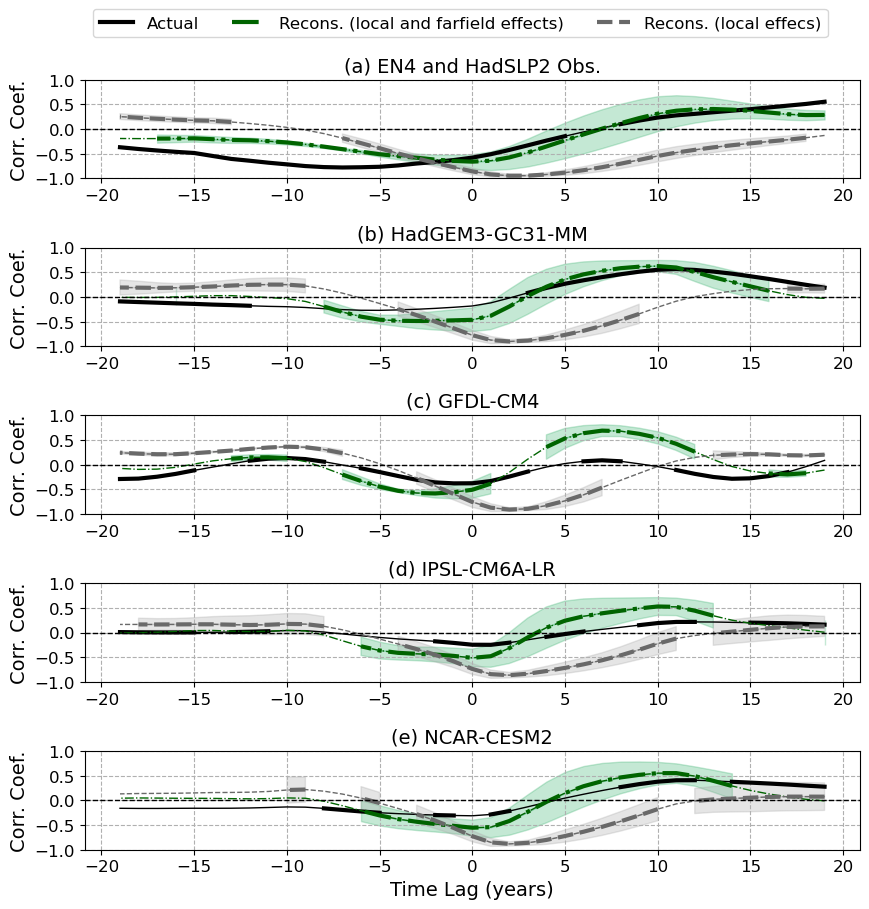

In [35]:
grid1 = plt.GridSpec(5, 1, wspace=0.1, hspace=0.7)
fig = plt.figure(figsize=[10,10])

legend_list = ['HadGEM3-GC31-MM', 'GFDL-CM4', 'IPSL-CM6A-LR', 'NCAR-CESM2', 'EN4 and HadSLP2 Obs.']
fs = 14

for j in range(0,1):
    for i in range(0, 5):
        if(i==4):
            ax = fig.add_subplot(grid1[0, j])
        else:
            ax = fig.add_subplot(grid1[i+1, j])

        ax.plot(20-np.arange(1, 40), corr_T_obs_mn[i, j,:], lw =1., color='black')
        tmp = np.where(pval_corr_T_obs_mn[i, j,:] <= 0.05, corr_T_obs_mn[i, j,:], np.nan)
        ax.plot(20-np.arange(1, 40), tmp, lw =3., color='black', label= 'Actual')
        
        ax.plot(20-np.arange(1, 40), corr_T_pred_mn[i, j,:], lw =1., ls='-.', color='darkgreen')
        tmp = np.where(pval_corr_T_pred_mn[i, j,:] <= 0.05, corr_T_pred_mn[i, j,:], np.nan)
        ax.plot(20-np.arange(1, 40), tmp, lw =3., ls='-.', color='darkgreen', 
                label= 'Recons. (local and farfield effects)')
        
        ax.fill_between(20-np.arange(1, 40), tmp, tmp + corr_T_pred_std[i, j,:], 
                        alpha=0.3, color='mediumseagreen')
        ax.fill_between(20-np.arange(1, 40), tmp, tmp - corr_T_pred_std[i, j,:], 
                        alpha=0.3, color='mediumseagreen')
        
        ax.plot(20-np.arange(1, 40), corr_T_pred_local_mn[i, j,:], lw =1., ls='--', color='dimgrey')
        tmp = np.where(pval_corr_T_pred_local_mn[i, j,:] <= 0.05, corr_T_pred_local_mn[i, j,:], np.nan)
        ax.plot(20-np.arange(1, 40), tmp, lw =3., ls='--', color='dimgrey', label= 'Recons. (local effecs)')
        
        ax.fill_between(20-np.arange(1, 40), tmp, tmp + corr_T_pred_local_std[i, j,:], 
                        alpha=0.3, color='darkgrey')
        ax.fill_between(20-np.arange(1, 40), tmp, tmp - corr_T_pred_local_std[i, j,:], 
                        alpha=0.3, color='darkgrey')

    
        plt.xticks(fontsize=12); plt.yticks(fontsize=12);
        ax.set_ylim([-1.0, 1.0])
        ax.grid(ls='--')
        ax.axhline(y=0., ls='--', lw=1., color='k')

        ax.set_ylabel('Corr. Coef.', fontsize=fs)
        ax.set_yticks([-1, -0.5, 0, 0.5, 1])
        if(i<4):
            ax.set_title('(' + chr(98+i) + ') '+ legend_list[i],fontsize=fs)
        else:
            ax.set_title('(' + chr(97) + ') '+ legend_list[i],fontsize=fs)
            
        if(i==3):
            ax.set_xlabel('Time Lag (years)', fontsize=fs)
            
        if(i==4):
            ax.legend(loc='upper left', bbox_to_anchor=(0., 1.8), fontsize=12, ncol=3)

fig.savefig('/home/users/hkhatri/Plots/Figures_GRL_2024/Corr_NAO_Theta.png', dpi=300,bbox_inches='tight');
fig.savefig('/home/users/hkhatri/Plots/Figures_GRL_2024/Corr_NAO_Theta.pdf', dpi=300,bbox_inches='tight');

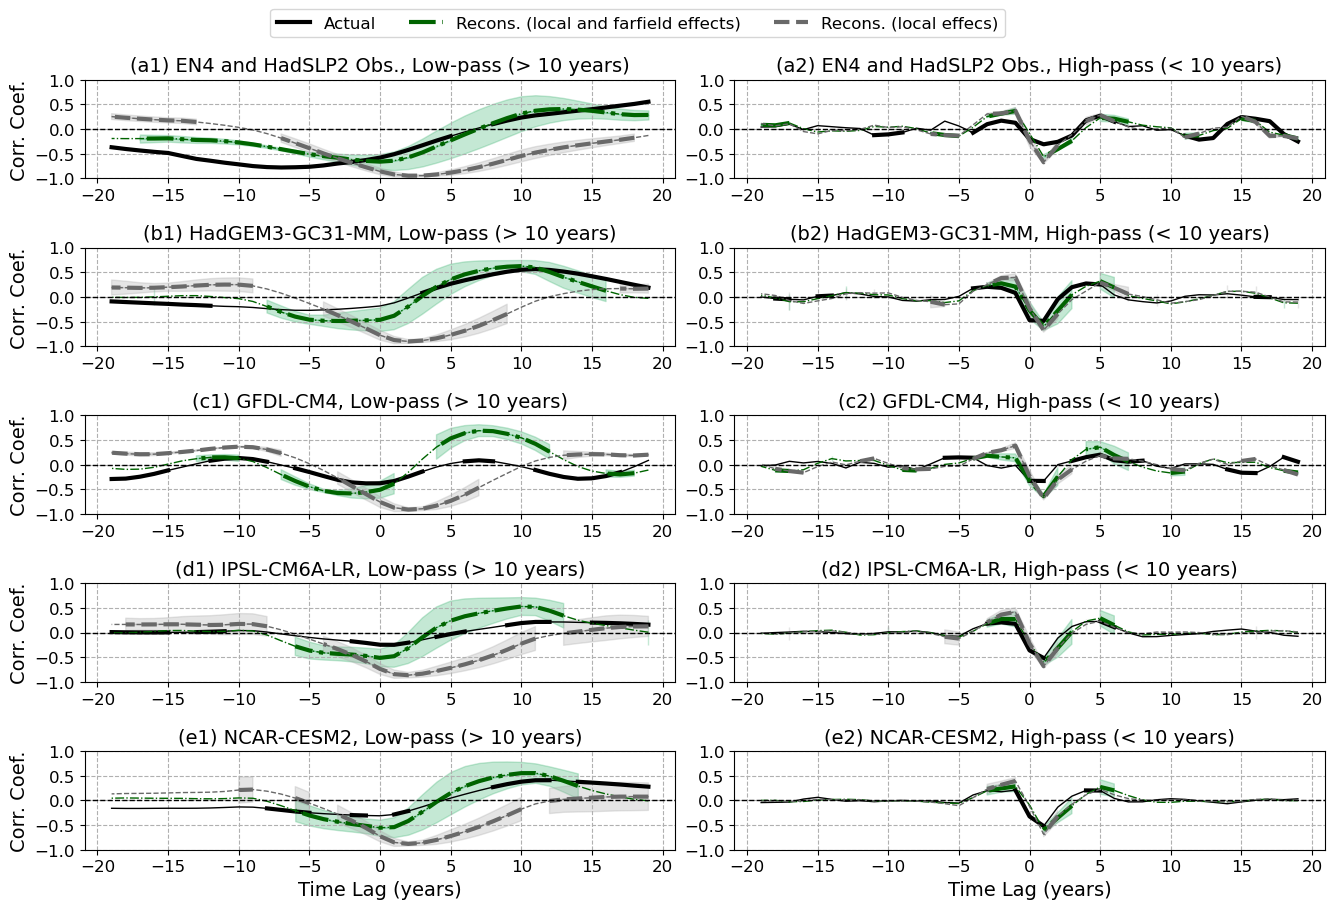

In [39]:
# Left column is the same as above. In the right column, correlations with high-pass filtered data are shown.
# This figure is part of the supporting information.

grid1 = plt.GridSpec(5, 2, wspace=0.1, hspace=0.7)
fig = plt.figure(figsize=[16,10])

legend_list = ['HadGEM3-GC31-MM', 'GFDL-CM4', 'IPSL-CM6A-LR', 'NCAR-CESM2', 'EN4 and HadSLP2 Obs.']
fs = 14

for j in range(0,2):
    for i in range(0, 5):
        if(i==4):
            ax = fig.add_subplot(grid1[0, j])
        else:
            ax = fig.add_subplot(grid1[i+1, j])
            
        ax.plot(20-np.arange(1, 40), corr_T_obs_mn[i, j,:], lw =1., color='black')
        tmp = np.where(pval_corr_T_obs_mn[i, j,:] <= 0.05, corr_T_obs_mn[i, j,:], np.nan)
        ax.plot(20-np.arange(1, 40), tmp, lw =3., color='black', label= 'Actual')
        
        ax.plot(20-np.arange(1, 40), corr_T_pred_mn[i, j,:], lw =1., ls='-.', color='darkgreen')
        tmp = np.where(pval_corr_T_pred_mn[i, j,:] <= 0.05, corr_T_pred_mn[i, j,:], np.nan)
        ax.plot(20-np.arange(1, 40), tmp, lw =3., ls='-.', color='darkgreen', 
                label= 'Recons. (local and farfield effects)')
        
        ax.fill_between(20-np.arange(1, 40), tmp, tmp + corr_T_pred_std[i, j,:], 
                        alpha=0.3, color='mediumseagreen')
        ax.fill_between(20-np.arange(1, 40), tmp, tmp - corr_T_pred_std[i, j,:], 
                        alpha=0.3, color='mediumseagreen')
        
        ax.plot(20-np.arange(1, 40), corr_T_pred_local_mn[i, j,:], lw =1., ls='--', color='dimgrey')
        tmp = np.where(pval_corr_T_pred_local_mn[i, j,:] <= 0.05, corr_T_pred_local_mn[i, j,:], np.nan)
        ax.plot(20-np.arange(1, 40), tmp, lw =3., ls='--', color='dimgrey', label= 'Recons. (local effecs)')
        
        ax.fill_between(20-np.arange(1, 40), tmp, tmp + corr_T_pred_local_std[i, j,:], 
                        alpha=0.3, color='darkgrey')
        ax.fill_between(20-np.arange(1, 40), tmp, tmp - corr_T_pred_local_std[i, j,:], 
                        alpha=0.3, color='darkgrey')

    
        plt.xticks(fontsize=12); plt.yticks(fontsize=12);
        ax.set_ylim([-1.0, 1.0])
        ax.grid(ls='--')
        ax.axhline(y=0., ls='--', lw=1., color='k')
        ax.set_yticks([-1, -0.5, 0, 0.5, 1])
        if(j==0):
            ax.set_ylabel('Corr. Coef.', fontsize=fs)
            if(i<4):
                ax.set_title('(' + chr(98+i) + str(j+1) + ') '+ legend_list[i] + 
                             ', Low-pass (> 10 years)',fontsize=fs)
            else:
                ax.set_title('(' + chr(97) + str(j+1) + ') '+ legend_list[i] + 
                             ', Low-pass (> 10 years)',fontsize=fs)
        else:
            if(i<4):
                ax.set_title('(' + chr(98+i) + str(j+1) + ') '+ legend_list[i] + 
                             ', High-pass (< 10 years)',fontsize=fs)
            else:
                ax.set_title('(' + chr(97) + str(j+1) + ') '+ legend_list[i] + 
                             ', High-pass (< 10 years)',fontsize=fs)
            
        if(i==3):
            ax.set_xlabel('Time Lag (years)', fontsize=fs)
            
        if(j==1 and i==4):
            ax.legend(loc='upper left', bbox_to_anchor=(-0.8, 1.8), fontsize=12, ncol=3)

fig.savefig('/home/users/hkhatri/Plots/Figures_GRL_2024/SI_Corr_NAO_Theta.png', dpi=300,bbox_inches='tight');
fig.savefig('/home/users/hkhatri/Plots/Figures_GRL_2024/SI_Corr_NAO_Theta.pdf', dpi=300,bbox_inches='tight');


#### Next, we plot a figure the same as the above for AMV index (SST anomalies in the whole North Atlantic).

#### It would show that green's function approach and NAO-based reconstructions can be used the understand the AMV. This figure is in the supportin information. 

In [42]:
%%time

# get temperature-NAO correlations at diferent lead-lag times

rho_cp = 4.09 * 1.e6 # constant from Williams et al. 2015

corr_T_obs_mn = np.zeros((5, 2,39)) # for chosen four cmip models and observations
pval_corr_T_obs_mn = np.zeros((5, 2,39)) # for p-values in correlations

corr_T_pred_mn = np.zeros((5, 2, 39)) # with local and farfield efects
corr_T_pred_std = np.zeros((5, 2,39))
pval_corr_T_pred_mn = np.zeros((5, 2, 39)) # for p-values in correlations
pval_corr_T_pred_std = np.zeros((5, 2,39))

corr_T_pred_local_mn = np.zeros((5, 2,39)) # without farfield effects
corr_T_pred_local_std = np.zeros((5, 2,39))
pval_corr_T_pred_local_mn = np.zeros((5, 2, 39)) # for p-values in correlations
pval_corr_T_pred_local_std = np.zeros((5, 2,39))

for i in range(0, len(dsh)):

    print("Model running - ", str(i+1)) 

    tau_beta = dsh_cor[i]['tau'] * 1.5 * np.pi / dsh_cor[i]['beta']

    NAO = dsh[i]['NAO'] #.isel(r = 0)
    T_obs = dsh[i]['sst_AMV'] 
    NAO = detrend(NAO, ['time']) # detrend and remove time-mean
    T_obs = detrend(T_obs, ['time'])

    days = NAO['time'].dt.daysinmonth
    NAO = NAO - (NAO*days).sum('time') / days.sum('time')
    T_obs = T_obs - (T_obs*days).sum('time') / days.sum('time')
    
    # With local and farfield effects
    corr_r = dsh_cor[i]['HC200_Corr_r'] #.isel(r = 0)
    mem_chose = corr_r.where((corr_r > 0.4) & (corr_r['tau']>= 1.)) # arbitrary cut-off
    mem_chose = mem_chose.where(tau_beta < -corr_r['tau'] * np.log(0.05))
    mem_chose = mem_chose.where(dsh_cor[i]['HC200_Corr_p'].isel(r=0) <0.01)

    T_pred = dsh[i]['HC200_Pred'] #.isel(r=0)
    T_pred = T_pred.where((mem_chose<1.) & (mem_chose>-1.)) # get timeseries for chosen correlation points
    T_pred = detrend(T_pred, ['time'])
    T_pred = T_pred - (T_pred*days).sum('time') / days.sum('time')

    # With local effects only
    corr_r = dsh_cor[i]['HC200_Corr_r']
    mem_chose = corr_r.where((corr_r['tau']>= 1.) & (corr_r['tau']<= 6.) & (corr_r['beta']== 0.))
    T_pred_local = dsh[i]['HC200_Pred']
    T_pred_local = T_pred_local.where((mem_chose<1.) & (mem_chose>-1.)) # get timeseries for chosen correlation points
    T_pred_local = detrend(T_pred_local, ['time'])
    T_pred_local = T_pred_local - (T_pred_local*days).sum('time') / days.sum('time')

    # Try to reproduce NAO-temperature correlations shown in Delworth et al (2017)
    LP_NAO = Moving_Avg(NAO, time = NAO['time'], time_len = 10*12) # longer than 10 years
    HP_NAO = NAO - LP_NAO
    HP_NAO = Moving_Avg(HP_NAO, time = NAO['time'], time_len = 12) #annually-filtered at timescales shorter than 10 years
    
    LP_T_obs = Moving_Avg(T_obs, time = NAO['time'], time_len = 10*12)
    HP_T_obs = T_obs - LP_T_obs
    HP_T_obs = Moving_Avg(HP_T_obs, time = NAO['time'], time_len = 12)
    
    LP_T_pred = Moving_Avg(T_pred, time = NAO['time'], time_len = 10*12)
    HP_T_pred = T_pred - LP_T_pred
    HP_T_pred = Moving_Avg(HP_T_pred, time = NAO['time'], time_len = 12)

    LP_T_pred_local = Moving_Avg(T_pred_local, time = NAO['time'], time_len = 10*12)
    HP_T_pred_local = T_pred_local - LP_T_pred_local
    HP_T_pred_local = Moving_Avg(HP_T_pred_local, time = NAO['time'], time_len = 12)
    
    for j in range(1, 40):
        cor = xs.pearson_r(LP_NAO.isel(time=slice(j*12,len(NAO.time) - (40-j)*12)).drop('time'), 
                           LP_T_obs.isel(time=slice(20*12,len(NAO.time) - 20*12)).drop('time'), 
                           dim='time', skipna=True) # low-pass
        corr_T_obs_mn[i, 0, j-1] = cor.mean('r').values

        cor_p = xs.pearson_r_p_value(LP_NAO.isel(time=slice(j*12,len(NAO.time) - (40-j)*12)).drop('time'), 
                           LP_T_obs.isel(time=slice(20*12,len(NAO.time) - 20*12)).drop('time'), 
                           dim='time', skipna=True) # low-pass
        pval_corr_T_obs_mn[i, 0, j-1] = cor_p.mean('r').values 
        
        cor = xs.pearson_r(HP_NAO.isel(time=slice(j*12,len(NAO.time) - (40-j)*12)).drop('time'), 
                           HP_T_obs.isel(time=slice(20*12,len(NAO.time) - 20*12)).drop('time'), 
                           dim='time', skipna=True) # high-pass
        corr_T_obs_mn[i, 1, j-1] = cor.mean('r').values

        cor_p = xs.pearson_r_p_value(HP_NAO.isel(time=slice(j*12,len(NAO.time) - (40-j)*12)).drop('time'), 
                           HP_T_obs.isel(time=slice(20*12,len(NAO.time) - 20*12)).drop('time'), 
                           dim='time', skipna=True) # high-pass
        pval_corr_T_obs_mn[i, 1, j-1] = cor_p.mean('r').values

        # With local and farfield effects
        cor = xs.pearson_r(LP_NAO.isel(time=slice(j*12,len(NAO.time) - (40-j)*12)).drop('time'), 
                           LP_T_pred.isel(time=slice(20*12,len(NAO.time) - 20*12)).drop('time'), 
                           dim='time', skipna=True) # low-pass
        corr_T_pred_mn[i, 0, j-1] = cor.mean(['tau', 'beta', 'r']).values
        corr_T_pred_std[i, 0, j-1] = cor.std(['tau', 'beta', 'r']).values

        cor_p = xs.pearson_r_p_value(LP_NAO.isel(time=slice(j*12,len(NAO.time) - (40-j)*12)).drop('time'), 
                           LP_T_pred.isel(time=slice(20*12,len(NAO.time) - 20*12)).drop('time'), 
                           dim='time', skipna=True) # low-pass
        pval_corr_T_pred_mn[i, 0, j-1] = cor_p.mean(['tau', 'beta', 'r']).values
        
        cor = xs.pearson_r(HP_NAO.isel(time=slice(j*12,len(NAO.time) - (40-j)*12)).drop('time'), 
                           HP_T_pred.isel(time=slice(20*12,len(NAO.time) - 20*12)).drop('time'), 
                           dim='time', skipna=True) # high-pass
        corr_T_pred_mn[i, 1, j-1] = cor.mean(['tau', 'beta', 'r']).values
        corr_T_pred_std[i, 1, j-1] = cor.std(['tau', 'beta', 'r']).values

        cor_p = xs.pearson_r_p_value(HP_NAO.isel(time=slice(j*12,len(NAO.time) - (40-j)*12)).drop('time'), 
                           HP_T_pred.isel(time=slice(20*12,len(NAO.time) - 20*12)).drop('time'), 
                           dim='time', skipna=True) # high-pass
        pval_corr_T_pred_mn[i, 1, j-1] = cor_p.mean(['tau', 'beta', 'r']).values
        
        # With local effects
        cor = xs.pearson_r(LP_NAO.isel(time=slice(j*12,len(NAO.time) - (40-j)*12)).drop('time'), 
                           LP_T_pred_local.isel(time=slice(20*12,len(NAO.time) - 20*12)).drop('time'), 
                           dim='time', skipna=True) # low-pass
        corr_T_pred_local_mn[i, 0, j-1] = cor.mean(['tau', 'beta', 'r']).values
        corr_T_pred_local_std[i, 0, j-1] = cor.std(['tau', 'beta', 'r']).values

        cor_p = xs.pearson_r_p_value(LP_NAO.isel(time=slice(j*12,len(NAO.time) - (40-j)*12)).drop('time'), 
                           LP_T_pred_local.isel(time=slice(20*12,len(NAO.time) - 20*12)).drop('time'), 
                           dim='time', skipna=True) # low-pass
        pval_corr_T_pred_local_mn[i, 0, j-1] = cor_p.mean(['tau', 'beta', 'r']).values
        
        cor = xs.pearson_r(HP_NAO.isel(time=slice(j*12,len(NAO.time) - (40-j)*12)).drop('time'), 
                           HP_T_pred_local.isel(time=slice(20*12,len(NAO.time) - 20*12)).drop('time'), 
                           dim='time', skipna=True) # high-pass
        corr_T_pred_local_mn[i, 1, j-1] = cor.mean(['tau', 'beta', 'r']).values
        corr_T_pred_local_std[i, 1, j-1] = cor.std(['tau', 'beta', 'r']).values
        
        cor_p = xs.pearson_r_p_value(HP_NAO.isel(time=slice(j*12,len(NAO.time) - (40-j)*12)).drop('time'), 
                           HP_T_pred_local.isel(time=slice(20*12,len(NAO.time) - 20*12)).drop('time'), 
                           dim='time', skipna=True) # high-pass
        pval_corr_T_pred_local_mn[i, 1, j-1] = cor_p.mean(['tau', 'beta', 'r']).values

Model running -  1
Model running -  2
Model running -  3
Model running -  4
CPU times: user 8min 43s, sys: 5min 39s, total: 14min 22s
Wall time: 14min 36s


In [44]:
%%time 

year1, year2 = (1901, 2021) # range years for correlations

# correlations for observations
tau_beta = ds_cor_hist['tau'] * 1.5 * np.pi / ds_cor_hist['beta']

ds_NAO = xr.open_dataset(ppdir + "Observations/NAO_HadSLP.nc", use_cftime=True)

NAO = (ds_NAO['NAO_point']) # climatology was substracted
T_obs = ds_cor_hist['sst_AMV']

NAO = NAO.sel(time = NAO['time.year'] >= year1); NAO = NAO.sel(time = NAO['time.year'] <= year2);
T_obs = T_obs.sel(time = T_obs['time.year'] >= year1); T_obs = T_obs.sel(time = T_obs['time.year'] <= year2);

NAO = detrend(NAO, ['time']) # detrend and remove time-mean
T_obs = detrend(T_obs, ['time']); 
T_obs = T_obs.drop('time')

days = NAO['time'].dt.daysinmonth
NAO = NAO - (NAO*days).sum('time') / days.sum('time')
T_obs = T_obs - (T_obs*days).sum('time') / days.sum('time')

# With local and farfield effects
corr_r = ds_cor_hist['HC200_Corr_r']
mem_chose = corr_r.where((corr_r > 0.4) & (corr_r['tau']>= 1.)) # arbitrary cut-off
mem_chose = mem_chose.where(tau_beta < -corr_r['tau'] * np.log(0.05))
mem_chose = mem_chose.where(ds_cor_hist['HC200_Corr_p'] < 0.01)

T_pred = ds_cor_hist['HC200_Pred']
T_pred = T_pred.sel(time = T_pred['time.year'] >= year1); T_pred = T_pred.sel(time = T_pred['time.year'] <= year2);
T_pred = T_pred.where((mem_chose<1.) & (mem_chose>-1.)) # get timeseries for chosen correlation points
T_pred = detrend(T_pred, ['time'])
T_pred = T_pred.drop('time')
T_pred = T_pred - (T_pred*days).sum('time') / days.sum('time')

# With local effects only
corr_r = ds_cor_hist['HC200_Corr_r']
mem_chose = corr_r.where((corr_r['tau']>= 1.) & (corr_r['tau']<= 6.) & (corr_r['beta']== 0.))
T_pred_local = ds_cor_hist['HC200_Pred']
T_pred_local = T_pred_local.sel(time = T_pred_local['time.year'] >= year1); 
T_pred_local = T_pred_local.sel(time = T_pred_local['time.year'] <= year2);
T_pred_local = T_pred_local.where((mem_chose<1.) & (mem_chose>-1.)) # get timeseries for chosen correlation points
T_pred_local = detrend(T_pred_local, ['time'])
T_pred_local = T_pred_local.drop('time')
T_pred_local = T_pred_local - (T_pred_local*days).sum('time') / days.sum('time')

# Try to reproduce NAO-temperature correlations shown in Delworth et al (2017)
LP_NAO = Moving_Avg(NAO, time = NAO['time'], time_len = 10*12) # longer than 10 years
HP_NAO = NAO - LP_NAO
HP_NAO = Moving_Avg(HP_NAO, time = NAO['time'], time_len = 12)
    
LP_T_obs = Moving_Avg(T_obs, time = NAO['time'], time_len = 10*12)
HP_T_obs = T_obs - LP_T_obs
HP_T_obs = Moving_Avg(HP_T_obs, time = NAO['time'], time_len = 12)
    
LP_T_pred = Moving_Avg(T_pred, time = NAO['time'], time_len = 10*12)
HP_T_pred = T_pred - LP_T_pred
HP_T_pred = Moving_Avg(HP_T_pred, time = NAO['time'], time_len = 12)

LP_T_pred_local = Moving_Avg(T_pred_local, time = NAO['time'], time_len = 10*12)
HP_T_pred_local = T_pred_local - LP_T_pred_local
HP_T_pred_local = Moving_Avg(HP_T_pred_local, time = NAO['time'], time_len = 12)

for j in range(1, 40):
    cor = xs.pearson_r(LP_NAO.isel(time=slice(j*12,len(NAO.time) - (40-j)*12)).drop('time'), 
                        LP_T_obs.isel(time=slice(20*12,len(NAO.time) - 20*12)), 
                        dim='time', skipna=True) # low-pass
    corr_T_obs_mn[4, 0, j-1] = cor.values

    cor_p = xs.pearson_r_p_value(LP_NAO.isel(time=slice(j*12,len(NAO.time) - (40-j)*12)).drop('time'), 
                        LP_T_obs.isel(time=slice(20*12,len(NAO.time) - 20*12)), 
                        dim='time', skipna=True) # low-pass
    pval_corr_T_obs_mn[4, 0, j-1] = cor_p.values
        
    cor = xs.pearson_r(HP_NAO.isel(time=slice(j*12,len(NAO.time) - (40-j)*12)).drop('time'), 
                        HP_T_obs.isel(time=slice(20*12,len(NAO.time) - 20*12)), 
                        dim='time', skipna=True) # high-pass
    corr_T_obs_mn[4, 1, j-1] = cor.values
    
    cor_p = xs.pearson_r_p_value(HP_NAO.isel(time=slice(j*12,len(NAO.time) - (40-j)*12)).drop('time'), 
                        HP_T_obs.isel(time=slice(20*12,len(NAO.time) - 20*12)), 
                        dim='time', skipna=True) # high-pass
    pval_corr_T_obs_mn[4, 1, j-1] = cor_p.values

    # With local and farfield effects
    cor = xs.pearson_r(LP_NAO.isel(time=slice(j*12,len(NAO.time) - (40-j)*12)).drop('time'), 
                        LP_T_pred.isel(time=slice(20*12,len(NAO.time) - 20*12)), 
                        dim='time', skipna=True) # low-pass
    corr_T_pred_mn[4, 0, j-1] = cor.mean(['tau', 'beta']).values
    corr_T_pred_std[4, 0, j-1] = cor.std(['tau', 'beta']).values

    cor_p = xs.pearson_r_p_value(LP_NAO.isel(time=slice(j*12,len(NAO.time) - (40-j)*12)).drop('time'), 
                        LP_T_pred.isel(time=slice(20*12,len(NAO.time) - 20*12)), 
                        dim='time', skipna=True) # low-pass
    pval_corr_T_pred_mn[4, 0, j-1] = cor_p.mean(['tau', 'beta']).values
        
    cor = xs.pearson_r(HP_NAO.isel(time=slice(j*12,len(NAO.time) - (40-j)*12)).drop('time'), 
                        HP_T_pred.isel(time=slice(20*12,len(NAO.time) - 20*12)), 
                        dim='time', skipna=True) # high-pass
    corr_T_pred_mn[4, 1, j-1] = cor.mean(['tau', 'beta']).values
    corr_T_pred_std[4, 1, j-1] = cor.std(['tau', 'beta']).values
    
    cor_p = xs.pearson_r_p_value(HP_NAO.isel(time=slice(j*12,len(NAO.time) - (40-j)*12)).drop('time'), 
                        HP_T_pred.isel(time=slice(20*12,len(NAO.time) - 20*12)), 
                        dim='time', skipna=True) # high-pass
    pval_corr_T_pred_mn[4, 1, j-1] = cor_p.mean(['tau', 'beta']).values
        
    # With local effects
    cor = xs.pearson_r(LP_NAO.isel(time=slice(j*12,len(NAO.time) - (40-j)*12)).drop('time'), 
                        LP_T_pred_local.isel(time=slice(20*12,len(NAO.time) - 20*12)), 
                        dim='time', skipna=True) # low-pass
    corr_T_pred_local_mn[4, 0, j-1] = cor.mean(['tau', 'beta']).values
    corr_T_pred_local_std[4, 0, j-1] = cor.std(['tau', 'beta']).values
    
    cor_p = xs.pearson_r_p_value(LP_NAO.isel(time=slice(j*12,len(NAO.time) - (40-j)*12)).drop('time'), 
                        LP_T_pred_local.isel(time=slice(20*12,len(NAO.time) - 20*12)), 
                        dim='time', skipna=True) # low-pass
    pval_corr_T_pred_local_mn[4, 0, j-1] = cor_p.mean(['tau', 'beta']).values
        
    cor = xs.pearson_r(HP_NAO.isel(time=slice(j*12,len(NAO.time) - (40-j)*12)).drop('time'), 
                        HP_T_pred_local.isel(time=slice(20*12,len(NAO.time) - 20*12)).drop('time'), 
                        dim='time', skipna=True) # high-pass
    corr_T_pred_local_mn[4, 1, j-1] = cor.mean(['tau', 'beta']).values
    corr_T_pred_local_std[4, 1, j-1] = cor.std(['tau', 'beta']).values
    
    cor_p = xs.pearson_r_p_value(HP_NAO.isel(time=slice(j*12,len(NAO.time) - (40-j)*12)).drop('time'), 
                        HP_T_pred_local.isel(time=slice(20*12,len(NAO.time) - 20*12)).drop('time'), 
                        dim='time', skipna=True) # high-pass
    pval_corr_T_pred_local_mn[4, 1, j-1] = cor_p.mean(['tau', 'beta']).values

CPU times: user 16.4 s, sys: 216 ms, total: 16.7 s
Wall time: 16.1 s


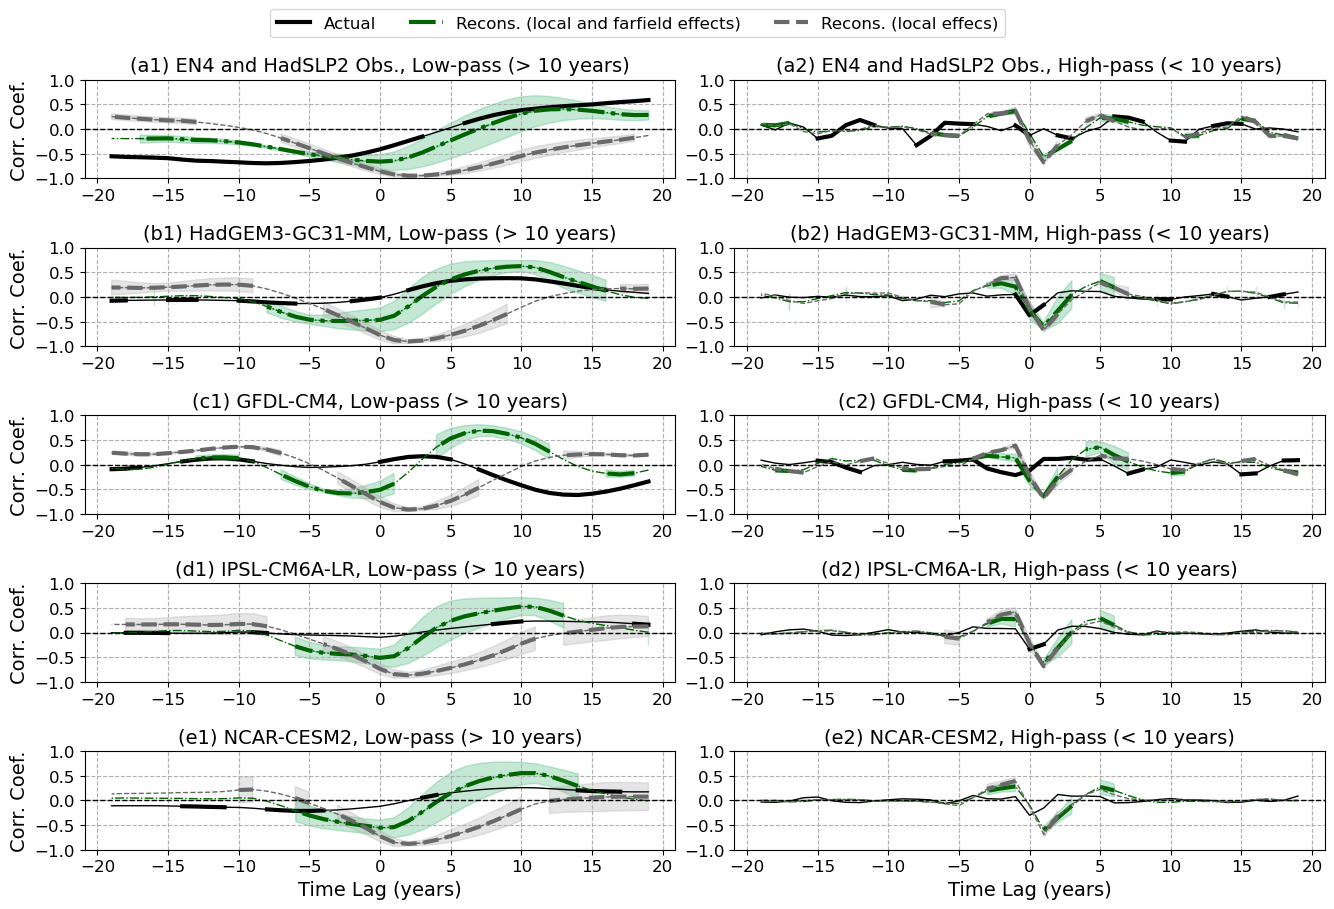

In [46]:
# Left column is the same as above. In the right column, correlations with high-pass filtered data are shown.
# This figure is part of the supporting information.

grid1 = plt.GridSpec(5, 2, wspace=0.1, hspace=0.7)
fig = plt.figure(figsize=[16,10])

legend_list = ['HadGEM3-GC31-MM', 'GFDL-CM4', 'IPSL-CM6A-LR', 'NCAR-CESM2', 'EN4 and HadSLP2 Obs.']
fs = 14

for j in range(0,2):
    for i in range(0, 5):
        if(i==4):
            ax = fig.add_subplot(grid1[0, j])
        else:
            ax = fig.add_subplot(grid1[i+1, j])
            
        ax.plot(20-np.arange(1, 40), corr_T_obs_mn[i, j,:], lw =1., color='black')
        tmp = np.where(pval_corr_T_obs_mn[i, j,:] <= 0.05, corr_T_obs_mn[i, j,:], np.nan)
        ax.plot(20-np.arange(1, 40), tmp, lw =3., color='black', label= 'Actual')
        
        ax.plot(20-np.arange(1, 40), corr_T_pred_mn[i, j,:], lw =1., ls='-.', color='darkgreen')
        tmp = np.where(pval_corr_T_pred_mn[i, j,:] <= 0.05, corr_T_pred_mn[i, j,:], np.nan)
        ax.plot(20-np.arange(1, 40), tmp, lw =3., ls='-.', color='darkgreen', 
                label= 'Recons. (local and farfield effects)')
        
        ax.fill_between(20-np.arange(1, 40), tmp, tmp + corr_T_pred_std[i, j,:], 
                        alpha=0.3, color='mediumseagreen')
        ax.fill_between(20-np.arange(1, 40), tmp, tmp - corr_T_pred_std[i, j,:], 
                        alpha=0.3, color='mediumseagreen')
        
        ax.plot(20-np.arange(1, 40), corr_T_pred_local_mn[i, j,:], lw =1., ls='--', color='dimgrey')
        tmp = np.where(pval_corr_T_pred_local_mn[i, j,:] <= 0.05, corr_T_pred_local_mn[i, j,:], np.nan)
        ax.plot(20-np.arange(1, 40), tmp, lw =3., ls='--', color='dimgrey', label= 'Recons. (local effecs)')
        
        ax.fill_between(20-np.arange(1, 40), tmp, tmp + corr_T_pred_local_std[i, j,:], 
                        alpha=0.3, color='darkgrey')
        ax.fill_between(20-np.arange(1, 40), tmp, tmp - corr_T_pred_local_std[i, j,:], 
                        alpha=0.3, color='darkgrey')

    
        plt.xticks(fontsize=12); plt.yticks(fontsize=12);
        ax.set_ylim([-1.0, 1.0])
        ax.grid(ls='--')
        ax.axhline(y=0., ls='--', lw=1., color='k')
        ax.set_yticks([-1, -0.5, 0, 0.5, 1])
        if(j==0):
            ax.set_ylabel('Corr. Coef.', fontsize=fs)
            if(i<4):
                ax.set_title('(' + chr(98+i) + str(j+1) + ') '+ legend_list[i] + 
                             ', Low-pass (> 10 years)',fontsize=fs)
            else:
                ax.set_title('(' + chr(97) + str(j+1) + ') '+ legend_list[i] + 
                             ', Low-pass (> 10 years)',fontsize=fs)
        else:
            if(i<4):
                ax.set_title('(' + chr(98+i) + str(j+1) + ') '+ legend_list[i] + 
                             ', High-pass (< 10 years)',fontsize=fs)
            else:
                ax.set_title('(' + chr(97) + str(j+1) + ') '+ legend_list[i] + 
                             ', High-pass (< 10 years)',fontsize=fs)
            
        if(i==3):
            ax.set_xlabel('Time Lag (years)', fontsize=fs)
            
        if(j==1 and i==4):
            ax.legend(loc='upper left', bbox_to_anchor=(-0.8, 1.8), fontsize=12, ncol=3)

fig.savefig('/home/users/hkhatri/Plots/Figures_GRL_2024/SI_Corr_NAO_AMV.png', dpi=300,bbox_inches='tight');
fig.savefig('/home/users/hkhatri/Plots/Figures_GRL_2024/SI_Corr_NAO_AMV.pdf', dpi=300,bbox_inches='tight');
